## Agentic RAG with Langchain v1, Ollama, and FAISS
**Key Features:**
- Agent-based architecture with autonomous tool usage for document retrieval
- FAISS vector store for efficient semantic search across document embeddings
- Ollama integration with Qwen3 LLM and nomic-embed-text embeddings for local deployment
- Custom retrieval tool that finds and formats relevant document chunks with metadata
- Interactive chat interface with streaming responses and tool call visibility

In [ ]:
# pip install -U langchain langchain-ollama, langchain-community langchain-core faiss-cpu
# ollama pull nomic-embed-text
# ollama pull qwen3

In [1]:
import os
import warnings
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv


load_dotenv()

True

In [2]:
# ============================================================================
# LLM & VECTOR STORE SETUP
# ============================================================================
# Ollama LLM with Qwen3
llm = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434"
)

# Ollama Embeddings
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# FAISS Vector Store (assumes data already exists from previous code)
db_name = "./../09. Vector Stores and Retrievals/health_supplements"
vector_store = FAISS.load_local(
    db_name,
    embeddings,
    allow_dangerous_deserialization=True
)

In [3]:
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T18:37:09.0211063Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5016900000, 'load_duration': 3140365300, 'prompt_eval_count': 11, 'prompt_eval_duration': 63223700, 'eval_count': 113, 'eval_duration': 1786919500, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--95cbceff-abfe-4c72-a428-0c360d7eebb9-0', usage_metadata={'input_tokens': 11, 'output_tokens': 113, 'total_tokens': 124})

In [8]:
# ============================================================================
# VECTOR STORE VERIFICATION
# ============================================================================
print("\n🔍 Testing Vector Store Connection...")

# Test 1: Check collection info
doc_count = vector_store.index.ntotal
print(f"✓ Vector store found with {doc_count} documents")


# Test 2: Sample similarity search
test_query = "creatine"
results = vector_store.similarity_search(test_query, k=3)
print(f"\n✓ Sample search for '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"  {i}. Source: {doc.metadata.get('source', '?')} (Page {doc.metadata.get('page', '?')}): {doc.page_content[:100]}...")




🔍 Testing Vector Store Connection...
✓ Vector store found with 311 documents

✓ Sample search for 'creatine':
  1. Source: rag-dataset\gym supplements\1. Analysis of Actual Fitness Supplement.pdf (Page 0): acids than traditional protein sources. Its numerous benefits have made it a popular choice
for snac...
  2. Source: rag-dataset\gym supplements\1. Analysis of Actual Fitness Supplement.pdf (Page 1): Foods 2024, 13, 1424
2 of 21
and sports industry, evidence suggests that creatine can benefit not on...
  3. Source: rag-dataset\gym supplements\2. High Prevalence of Supplement Intake.pdf (Page 10): supplements such as creatine or beta-alanine were used only once a week, which cannot be eﬀective [9...


In [6]:
results

[Document(id='fd6ca7af-09ea-44bf-b197-655128273c30', metadata={'producer': 'iLovePDF', 'creator': '', 'creationdate': '', 'source': 'rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'file_path': 'rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'total_pages': 15, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-10-21T11:38:50+00:00', 'trapped': '', 'modDate': 'D:20241021113850Z', 'creationDate': '', 'page': 0}, page_content='acids than traditional protein sources. Its numerous benefits have made it a popular choice\nfor snacks and drinks among consumers [3]. Another widely embraced supplement is\ncaffeine, which is found in many sports and food supplements. Caffeine reduces perceived\neffort, minimizes fatigue and pain, and proves to be effective for endurance and high-\nintensity activities, which is the choice of consumers [4].\nCreatine monohydrate is another well-known supplement 

In [ ]:
# ============================================================================
# RETRIEVAL TOOL
# ============================================================================
@tool()
def retrieve_context(query: str):
    """Retrieve relevant information for health related queries from the document to answer the query.
    
    """
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search
    docs = vector_store.similarity_search(query, k=4)
    
    # Format for LLM
    content = "\n\n".join(
        f"Source: {doc.metadata.get('source', '?')} (Page {doc.metadata.get('page', '?')}): {doc.page_content}"
        for doc in docs
    )
    
    print(f"✓ Found {len(docs)} relevant chunks")
    return content


In [16]:
result = retrieve_context.invoke("What is the use of BCAA?")
# print(result)

🔍 Searching: 'What is the use of BCAA?'
✓ Found 4 relevant chunks


#### Create Tools and Agent

In [17]:
tools = [retrieve_context]

system_prompt = """You are a research assistant with a document retrieval tool.

                    Tool:
                    - retrieve_context: Search the document for the health related question

                    Cite page numbers and reference document while writing the answer and be thorough."""

In [ ]:
# Create the agentic RAG
rag_agent = create_agent(llm, tools, system_prompt=system_prompt)

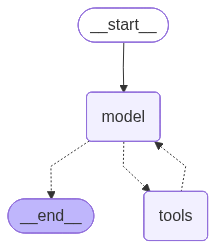

In [19]:
rag_agent

In [20]:
result = rag_agent.invoke({'messages': "What is the use of BCAA?"})

🔍 Searching: 'use of BCAA'
✓ Found 4 relevant chunks


In [21]:
result

{'messages': [HumanMessage(content='What is the use of BCAA?', additional_kwargs={}, response_metadata={}, id='7962cc8d-9750-441c-88e0-a3b65ffc490e'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T19:10:29.5876542Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7098807100, 'load_duration': 3511072700, 'prompt_eval_count': 196, 'prompt_eval_duration': 62607400, 'eval_count': 270, 'eval_duration': 3425281100, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--c667fbf2-6fbc-4494-81eb-b398180aa024-0', tool_calls=[{'name': 'retrieve_context', 'args': {'query': 'use of BCAA'}, 'id': '094215df-2046-4d85-89e6-5ed529949e06', 'type': 'tool_call'}], usage_metadata={'input_tokens': 196, 'output_tokens': 270, 'total_tokens': 466}),
  ToolMessage(content='Source: rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf (Page 1): Foods 2024, 13, 1424\n2 of 21\nand sports industry, evidence suggests

In [24]:
result['messages'][-1].pretty_print()

================================== Ai Message ==================================

Branched-Chain Amino Acids (BCAA) are primarily used for their role in muscle metabolism and recovery. According to the document **"1. Analysis of Actual Fitness Supplement.pdf" (Page 1)**, BCAAs are stored directly in muscles and serve as raw materials for building new muscle tissue. This process supports muscle strengthening and reduces post-workout soreness. Consumers often incorporate BCAA supplements into their routines to optimize fitness outcomes and enhance overall well-being [1]. 

The document also highlights that BCAAs are part of the sports supplement industry, which underscores their popularity among athletes and fitness enthusiasts aiming to improve performance and recovery [7]. 

**References:**  
- Page 1 of *1. Analysis of Actual Fitness Supplement.pdf* (Foods 2024, 13, 1424).


In [27]:
# ============================================================================
# QUERY FUNCTION
# ============================================================================
def ask(question: str):
    """Ask the agentic RAG a question."""
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)
    
    for event in rag_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values"
    ):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print("Tool Call: ")
                print(f"\n🔧 Using: {tc['name']} with {tc['args']}")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")

In [28]:
# ============================================================================
# TESTING
# ============================================================================
# Test basic retrieval
ask("how to gain muscle mass?")



Question: how to gain muscle mass?

💬 Answer:
how to gain muscle mass?
Tool Call: 

🔧 Using: retrieve_context with {'query': 'how to gain muscle mass'}
🔍 Searching: 'how to gain muscle mass'
✓ Found 4 relevant chunks

💬 Answer:
Source: rag-dataset\gym supplements\2. High Prevalence of Supplement Intake.pdf (Page 8): and strength gain among men. We detected more prevalent protein and creatine supplementation
among younger compared to older ﬁtness center users, whereas the opposite was found for vitamin
supplementation. Other authors made similar observations [23] and it might reﬂect the diﬀerent
training goals among age groups, i.e., more focus on strength and muscles among the younger and
more focus on health among the older age groups.
Comparable to other studies [4], we detected a positive correlation between training frequency
and supplement usage. Nevertheless, the correlation is weak and is deﬁnitely not a predictor at the
individual level. The subject with the highest supplement

In [29]:
ask("tell me 3 facts about Earth?")


Question: tell me 3 facts about Earth?

💬 Answer:
tell me 3 facts about Earth?

💬 Answer:
The query about Earth is not related to health, so I cannot use the provided tool to retrieve information. Here are three general facts about Earth:

1. **Third Planet from the Sun**: Earth is the third planet in our solar system and the only known celestial body to support life.  
2. **Unique Atmosphere**: Its atmosphere, rich in nitrogen and oxygen, along with the presence of liquid water, creates conditions suitable for life.  
3. **Dynamic Geology**: Earth is geologically active, with processes like plate tectonics, volcanism, and erosion shaping its surface over time.  

Let me know if you'd like health-related information!


In [30]:
# ============================================================================
# INTERACTIVE CHAT
# ============================================================================
def chat():
    """Start interactive chat with the agentic RAG."""
    print("\n🤖 Agentic RAG Chat - Type 'quit, q or exit' to exit")
    
    while True:
        question = input("\nYour question: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if question:
            ask(question)

chat()


🤖 Agentic RAG Chat - Type 'quit, q or exit' to exit

Question: tell me about sun?

💬 Answer:
tell me about sun?

💬 Answer:
The sun is a star at the center of our solar system, composed primarily of hydrogen (about 75%) and helium (about 25%), with trace amounts of heavier elements. It generates energy through nuclear fusion in its core, where hydrogen atoms fuse into helium, releasing vast amounts of light and heat. This process sustains the sun's luminosity and provides the energy necessary for life on Earth. The sun's surface temperature is approximately 5,500°C (9,932°F), while its core reaches temperatures of about 15 million°C (27 million°F). 

If you were asking about health-related aspects of the sun (e.g., sunlight's role in vitamin D synthesis or skin cancer risks), I could retrieve specific health information from a document. However, since your query is general, the above covers basic scientific details. Let me know if you'd like to focus on a specific aspect!

Question: te